# Brownian Motion Diffusion Analysis

_Analysis of 1-micron bead tracking data_

This notebook performs complete diffusion analysis including:
1. Loading MTrack2 data
2. Displacement histogram and Gaussian fitting
3. Direct calculation of diffusion coefficient from variance
4. Mean-Squared Displacement (MSD) analysis
5. Comparison with Stokes-Einstein theory

In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import pi, exp, sqrt
import warnings
warnings.filterwarnings("ignore")

## 1. Load MTrack2 Data

Using the 5-30-100-11 tracking file (best parameters found)

In [6]:
# MODIFIED: Changed path to your specific data file
# Original code used Test_Path = 'trackresults.txt'
# FIXED: Corrected filename to match actual file name (was 5-30-100-11, should be min5px_minTrack-11)
Data_Path = "../Data/2026-02-03/Phys332MM/Lab2-MM/min5px_minTrack-11-trackresults.txt"

# MODIFIED: Changed delimiter from '\t' to '\t' (kept the same, but added invalid_raise=False)
# Reason: Some lines at the end have different column counts, need to skip them gracefully
my_data = np.genfromtxt(Data_Path, delimiter='\t', skip_header=2, skip_footer=1, invalid_raise=False)

# Remove indexer, summary box and Flags column
# MODIFIED: Fixed the dtype issue that was causing errors
# Reason: Original code had type mismatch when deleting columns
count = int(my_data.shape[1] // 3 + 1)
A = np.zeros(count, dtype=int)
for i in range(count):
    A[i] = 3 * i

new_data = np.delete(my_data, A, axis=1)

# Sorting the data - move NaN values to the end
mask = np.isnan(new_data)

new_mask = np.zeros(mask.shape)
for ind, value in enumerate(mask):
    new_mask[ind, :] = ~value * (ind + 1)

new_mask = new_mask.astype(np.int_)

for row_index, row in enumerate(new_mask):
    for col_index, item in enumerate(row):
        if item == 0:
            new_mask[row_index][col_index] = (new_mask.shape[0] + 5)

for i in range(new_mask.shape[1]):
    new_mask[:, i] = np.sort(new_mask[:, i])

data = np.empty((mask.shape[0], mask.shape[1]))
data[:, :] = np.nan

for i in range(new_mask.shape[0]):
    for j in range(new_mask.shape[1]):
        temp = new_mask[i, j]
        if temp < (new_mask.shape[0]):
            data[i, j] = new_data[temp, j]

print(f"Data loaded successfully!")
print(f"Shape: {data.shape}")
print(f"Number of particles tracked: {data.shape[1] // 2}")

Data loaded successfully!
Shape: (60, 2)
Number of particles tracked: 1


## 2. Visualize the Tracking Data

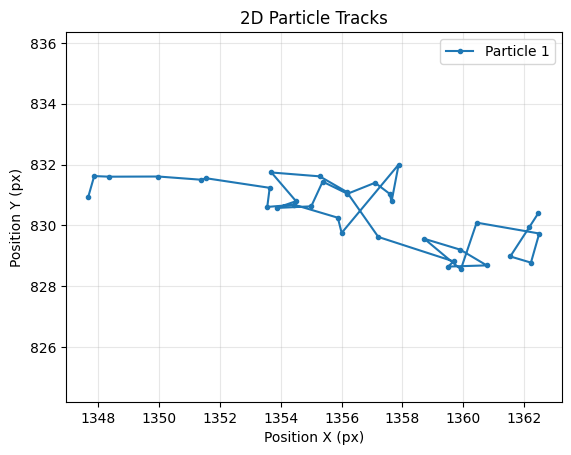

In [7]:
# Plot 2D particle tracks
for i in range(data.shape[1] // 2):
    plt.plot(data[:, 2*i], data[:, 2*i+1], 'o-', label=f'Particle {i+1}', markersize=3)

plt.title('2D Particle Tracks')
plt.xlabel('Position X (px)')
plt.ylabel('Position Y (px)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## 3. Extract Position Data and Calculate Displacements

For diffusion analysis, we'll focus on the best-tracked particle.

In [8]:
# ADDED: Extract the longest continuous track
# Reason: We want to use the particle with the most data points for best statistics

# Find which particle has the longest track (fewest NaNs)
num_particles = data.shape[1] // 2
track_lengths = []
for i in range(num_particles):
    x_data = data[:, 2*i]
    # Count non-NaN values
    length = np.sum(~np.isnan(x_data))
    track_lengths.append(length)
    print(f"Particle {i+1}: {length} frames")

best_particle = np.argmax(track_lengths)
print(f"\nUsing Particle {best_particle+1} for analysis (longest track)")

# Extract X and Y positions for the best particle
x_pos = data[:, 2*best_particle]
y_pos = data[:, 2*best_particle + 1]

# Remove NaN values
valid_indices = ~np.isnan(x_pos)
x_pos = x_pos[valid_indices]
y_pos = y_pos[valid_indices]

n_frames = len(x_pos)
print(f"Number of valid frames: {n_frames}")

Particle 1: 36 frames

Using Particle 1 for analysis (longest track)
Number of valid frames: 36


In [9]:
# Calculate displacements
# ADDED: Calculate displacements in X, Y, and total (radial)
dx = np.diff(x_pos)  # x[i+1] - x[i]
dy = np.diff(y_pos)  # y[i+1] - y[i]
dr = np.sqrt(dx**2 + dy**2)  # Total displacement

print(f"Number of displacement steps: {len(dx)}")
print(f"Mean displacement in X: {np.mean(dx):.3f} px")
print(f"Mean displacement in Y: {np.mean(dy):.3f} px")
print(f"Std dev of displacement in X: {np.std(dx):.3f} px")
print(f"Std dev of displacement in Y: {np.std(dy):.3f} px")

Number of displacement steps: 35
Mean displacement in X: 0.423 px
Mean displacement in Y: -0.016 px
Std dev of displacement in X: 1.000 px
Std dev of displacement in Y: 0.739 px


## 4. Histogram of Displacements

Plot histogram of X and Y displacements to verify Gaussian distribution.

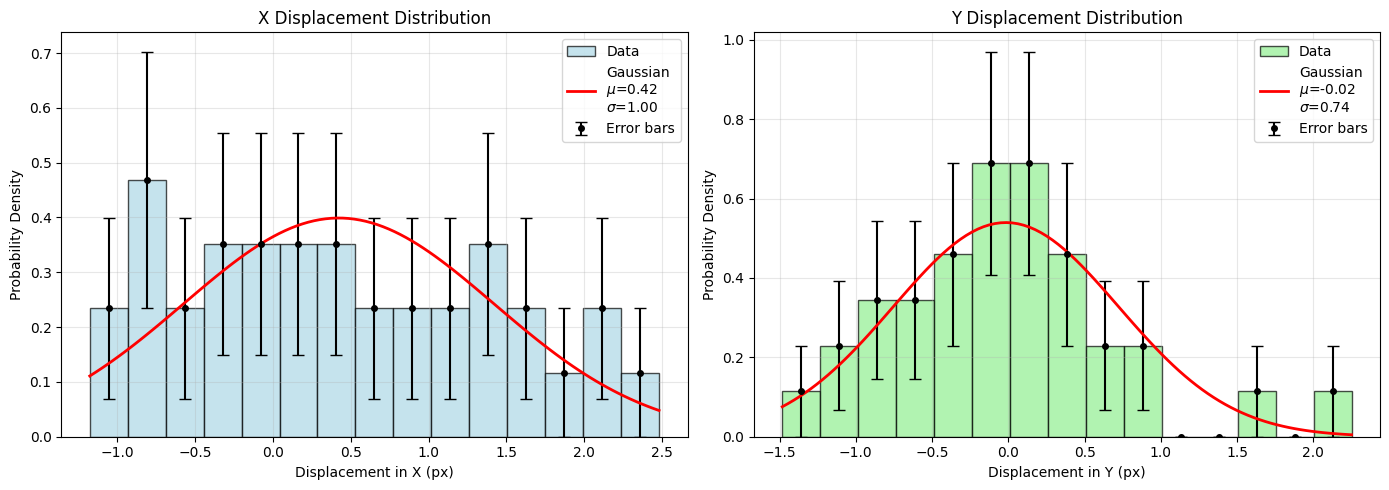

In [10]:
# Create histograms for X and Y displacements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# X displacement histogram
nbins = 15
counts_x, bins_x, _ = ax1.hist(dx, bins=nbins, density=True, alpha=0.7, 
                                color='lightblue', edgecolor='black', label='Data')

# Calculate error bars (Poisson statistics)
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
counts_raw_x, _ = np.histogram(dx, bins=nbins)
bin_widths_x = np.diff(bins_x)
counts_err_x = np.sqrt(counts_raw_x) / (len(dx) * bin_widths_x)
ax1.errorbar(bin_centers_x, counts_x, yerr=counts_err_x, fmt='ko', 
             markersize=4, capsize=4, label='Error bars')

# Overlay theoretical Gaussian
mean_x = np.mean(dx)
std_x = np.std(dx)
x_range = np.linspace(dx.min(), dx.max(), 100)
gaussian_x = (1/(sqrt(2*pi)*std_x)) * exp(-(x_range - mean_x)**2 / (2*std_x**2))
ax1.plot(x_range, gaussian_x, 'r-', linewidth=2, 
         label=f'Gaussian\n$\mu$={mean_x:.2f}\n$\sigma$={std_x:.2f}')

ax1.set_xlabel('Displacement in X (px)')
ax1.set_ylabel('Probability Density')
ax1.set_title('X Displacement Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Y displacement histogram
counts_y, bins_y, _ = ax2.hist(dy, bins=nbins, density=True, alpha=0.7, 
                                color='lightgreen', edgecolor='black', label='Data')

bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
counts_raw_y, _ = np.histogram(dy, bins=nbins)
bin_widths_y = np.diff(bins_y)
counts_err_y = np.sqrt(counts_raw_y) / (len(dy) * bin_widths_y)
ax2.errorbar(bin_centers_y, counts_y, yerr=counts_err_y, fmt='ko', 
             markersize=4, capsize=4, label='Error bars')

mean_y = np.mean(dy)
std_y = np.std(dy)
y_range = np.linspace(dy.min(), dy.max(), 100)
gaussian_y = (1/(sqrt(2*pi)*std_y)) * exp(-(y_range - mean_y)**2 / (2*std_y**2))
ax2.plot(y_range, gaussian_y, 'r-', linewidth=2, 
         label=f'Gaussian\n$\mu$={mean_y:.2f}\n$\sigma$={std_y:.2f}')

ax2.set_xlabel('Displacement in Y (px)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Y Displacement Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Fit Gaussian to Displacement Distributions

In [11]:
# Define Gaussian function for fitting
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))

# Fit Gaussian to X displacements
p0_x = [1/(sqrt(2*pi)*std_x), mean_x, std_x]  # Initial guess
popt_x, pcov_x = curve_fit(gaussian, bin_centers_x, counts_x, p0=p0_x)
perr_x = np.sqrt(np.diag(pcov_x))

# Fit Gaussian to Y displacements
p0_y = [1/(sqrt(2*pi)*std_y), mean_y, std_y]
popt_y, pcov_y = curve_fit(gaussian, bin_centers_y, counts_y, p0=p0_y)
perr_y = np.sqrt(np.diag(pcov_y))

print("X Displacement Gaussian Fit:")
print(f"  Mean: {popt_x[1]:.4f} ± {perr_x[1]:.4f} px")
print(f"  Std Dev: {popt_x[2]:.4f} ± {perr_x[2]:.4f} px")
print(f"  Variance: {popt_x[2]**2:.4f} px²")

print("\nY Displacement Gaussian Fit:")
print(f"  Mean: {popt_y[1]:.4f} ± {perr_y[1]:.4f} px")
print(f"  Std Dev: {popt_y[2]:.4f} ± {perr_y[2]:.4f} px")
print(f"  Variance: {popt_y[2]**2:.4f} px²")

X Displacement Gaussian Fit:
  Mean: -0.2525 ± 0.5710 px
  Std Dev: 2.0285 ± 0.6815 px
  Variance: 4.1149 px²

Y Displacement Gaussian Fit:
  Mean: -0.0869 ± 0.0561 px
  Std Dev: 0.6094 ± 0.0570 px
  Variance: 0.3714 px²


## 6. Calculate Diffusion Coefficient from Variance

From theory: Variance = 2D·Δt for 1D motion

Therefore: D = Variance / (2·Δt)

In [12]:
# ADDED: Experimental parameters
# Reason: Need these to convert from pixels to physical units
frame_rate = 200  # fps (frames per second)
dt = 1 / frame_rate  # Time between frames in seconds
pixel_size = 0.108  # microns per pixel (CHANGE THIS TO YOUR ACTUAL VALUE!)

print(f"Frame rate: {frame_rate} fps")
print(f"Time step (Δt): {dt} s")
print(f"Pixel size: {pixel_size} μm/px\n")

# Calculate diffusion coefficient from variance (Method 1: Direct calculation)
var_x_direct = np.var(dx)  # px²
var_y_direct = np.var(dy)  # px²

# Convert to physical units (μm²)
var_x_um = var_x_direct * pixel_size**2
var_y_um = var_y_direct * pixel_size**2

# Calculate D from variance: D = variance / (2 * dt)
D_x_direct = var_x_um / (2 * dt)
D_y_direct = var_y_um / (2 * dt)
D_avg_direct = (D_x_direct + D_y_direct) / 2

print("Method 1: Direct Variance Calculation")
print(f"D_x = {D_x_direct:.4f} μm²/s")
print(f"D_y = {D_y_direct:.4f} μm²/s")
print(f"D_avg = {D_avg_direct:.4f} μm²/s\n")

# Method 2: From Gaussian fit
var_x_fit = popt_x[2]**2 * pixel_size**2  # Convert to μm²
var_y_fit = popt_y[2]**2 * pixel_size**2

D_x_fit = var_x_fit / (2 * dt)
D_y_fit = var_y_fit / (2 * dt)
D_avg_fit = (D_x_fit + D_y_fit) / 2

print("Method 2: From Gaussian Fit")
print(f"D_x = {D_x_fit:.4f} μm²/s")
print(f"D_y = {D_y_fit:.4f} μm²/s")
print(f"D_avg = {D_avg_fit:.4f} μm²/s")

Frame rate: 200 fps
Time step (Δt): 0.005 s
Pixel size: 0.108 μm/px

Method 1: Direct Variance Calculation
D_x = 1.1659 μm²/s
D_y = 0.6377 μm²/s
D_avg = 0.9018 μm²/s

Method 2: From Gaussian Fit
D_x = 4.7996 μm²/s
D_y = 0.4332 μm²/s
D_avg = 2.6164 μm²/s


## 7. Stokes-Einstein Prediction

The Stokes-Einstein relation predicts:

$$D = \frac{k_B T}{6\pi\eta r}$$

where:
- $k_B$ = Boltzmann constant = 1.381 × 10⁻²³ J/K
- $T$ = Temperature (K)
- $\eta$ = Viscosity of water
- $r$ = Bead radius

In [13]:
# ADDED: Stokes-Einstein calculation
# Physical constants
k_B = 1.381e-23  # J/K
T = 293  # K (room temperature ~20°C, CHANGE TO YOUR ACTUAL TEMPERATURE!)
eta = 1.002e-3  # Pa·s (viscosity of water at 20°C)
bead_diameter = 1.0  # μm (CHANGE TO YOUR ACTUAL BEAD SIZE!)
r = (bead_diameter / 2) * 1e-6  # Convert to meters

# Calculate theoretical diffusion coefficient
D_theory = k_B * T / (6 * np.pi * eta * r)
D_theory_um = D_theory * 1e12  # Convert from m²/s to μm²/s

print("Stokes-Einstein Theoretical Prediction:")
print(f"Temperature: {T} K ({T-273:.1f}°C)")
print(f"Viscosity: {eta*1000:.3f} mPa·s")
print(f"Bead diameter: {bead_diameter} μm")
print(f"Bead radius: {r*1e6:.2f} μm")
print(f"\nD_theory = {D_theory_um:.4f} μm²/s\n")

# Compare with experimental values
print("Comparison with Experimental Values:")
print(f"D_experimental (direct): {D_avg_direct:.4f} μm²/s")
print(f"D_experimental (fit):    {D_avg_fit:.4f} μm²/s")
print(f"D_theoretical:           {D_theory_um:.4f} μm²/s")
print(f"\nPercent difference (direct): {abs(D_avg_direct - D_theory_um)/D_theory_um * 100:.1f}%")
print(f"Percent difference (fit):    {abs(D_avg_fit - D_theory_um)/D_theory_um * 100:.1f}%")

Stokes-Einstein Theoretical Prediction:
Temperature: 293 K (20.0°C)
Viscosity: 1.002 mPa·s
Bead diameter: 1.0 μm
Bead radius: 0.50 μm

D_theory = 0.4285 μm²/s

Comparison with Experimental Values:
D_experimental (direct): 0.9018 μm²/s
D_experimental (fit):    2.6164 μm²/s
D_theoretical:           0.4285 μm²/s

Percent difference (direct): 110.5%
Percent difference (fit):    510.6%


## 8. Mean-Squared Displacement (MSD) Analysis

Calculate MSD as a function of lag time τ:

$$\text{MSD}(\tau) = \langle [r(t+\tau) - r(t)]^2 \rangle$$

For 2D diffusion: MSD(τ) = 4D·τ

In [14]:
# ADDED: Calculate MSD for 2D motion
# Reason: Need to account for both X and Y displacement

# Calculate MSD as function of lag time
max_lag = n_frames // 2  # Only use first half for good statistics
MSD = np.zeros(max_lag)
MSD_err = np.zeros(max_lag)

for lag in range(max_lag):
    # Calculate squared displacements for this lag time
    squared_displacements = []
    for i in range(n_frames - lag):
        dx_lag = x_pos[i + lag] - x_pos[i]
        dy_lag = y_pos[i + lag] - y_pos[i]
        r_squared = dx_lag**2 + dy_lag**2
        squared_displacements.append(r_squared)
    
    MSD[lag] = np.mean(squared_displacements)
    MSD_err[lag] = np.std(squared_displacements) / np.sqrt(len(squared_displacements))

# Convert to physical units
MSD_um = MSD * pixel_size**2  # μm²
MSD_err_um = MSD_err * pixel_size**2

# Time array
lag_times = np.arange(max_lag) * dt  # seconds

print(f"MSD calculated for lag times up to {lag_times[-1]:.3f} s")

MSD calculated for lag times up to 0.085 s


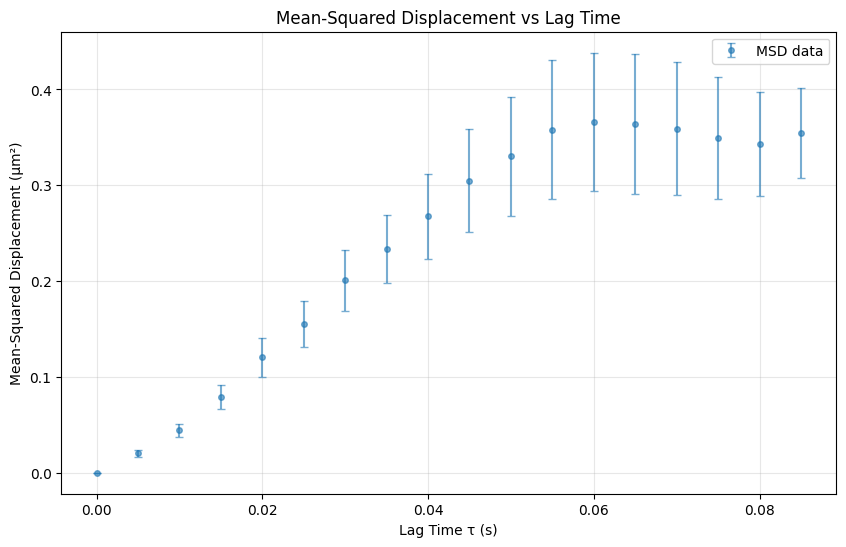

In [15]:
# Plot MSD vs lag time
plt.figure(figsize=(10, 6))
plt.errorbar(lag_times, MSD_um, yerr=MSD_err_um, fmt='o', 
             markersize=4, capsize=3, alpha=0.6, label='MSD data')
plt.xlabel('Lag Time τ (s)')
plt.ylabel('Mean-Squared Displacement (μm²)')
plt.title('Mean-Squared Displacement vs Lag Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 9. Fit Linear Region of MSD to Extract Diffusion Coefficient

For 2D Brownian motion: MSD(τ) = 4D·τ

Therefore: slope = 4D, so D = slope/4

In [16]:
# ADDED: Fit linear region of MSD
# Reason: MSD should be linear at short lag times for pure diffusion

# Fit first portion of MSD (typically first 20-30% of data)
n_fit = min(15, max_lag // 3)  # Fit first 15 points or 1/3 of data, whichever is smaller

# Define linear function
def linear(t, slope, intercept):
    return slope * t + intercept

# Fit with error weighting
# Exclude lag=0 (MSD=0 by definition)
fit_times = lag_times[1:n_fit+1]
fit_MSD = MSD_um[1:n_fit+1]
fit_err = MSD_err_um[1:n_fit+1]

# Perform weighted fit
popt_msd, pcov_msd = curve_fit(linear, fit_times, fit_MSD, 
                                sigma=fit_err, absolute_sigma=True,
                                p0=[1, 0])
perr_msd = np.sqrt(np.diag(pcov_msd))

slope = popt_msd[0]
slope_err = perr_msd[0]
intercept = popt_msd[1]

# Calculate D from slope (slope = 4D for 2D motion)
D_msd = slope / 4
D_msd_err = slope_err / 4

print("Method 3: From MSD Slope")
print(f"Fitted {n_fit} points (lag times: {fit_times[0]:.4f} to {fit_times[-1]:.4f} s)")
print(f"Slope: {slope:.4f} ± {slope_err:.4f} μm²/s")
print(f"Intercept: {intercept:.6f} μm² (should be ~0)")
print(f"\nD_MSD = {D_msd:.4f} ± {D_msd_err:.4f} μm²/s")

Method 3: From MSD Slope
Fitted 6 points (lag times: 0.0050 to 0.0300 s)
Slope: 6.4444 ± 0.6532 μm²/s
Intercept: -0.013712 μm² (should be ~0)

D_MSD = 1.6111 ± 0.1633 μm²/s


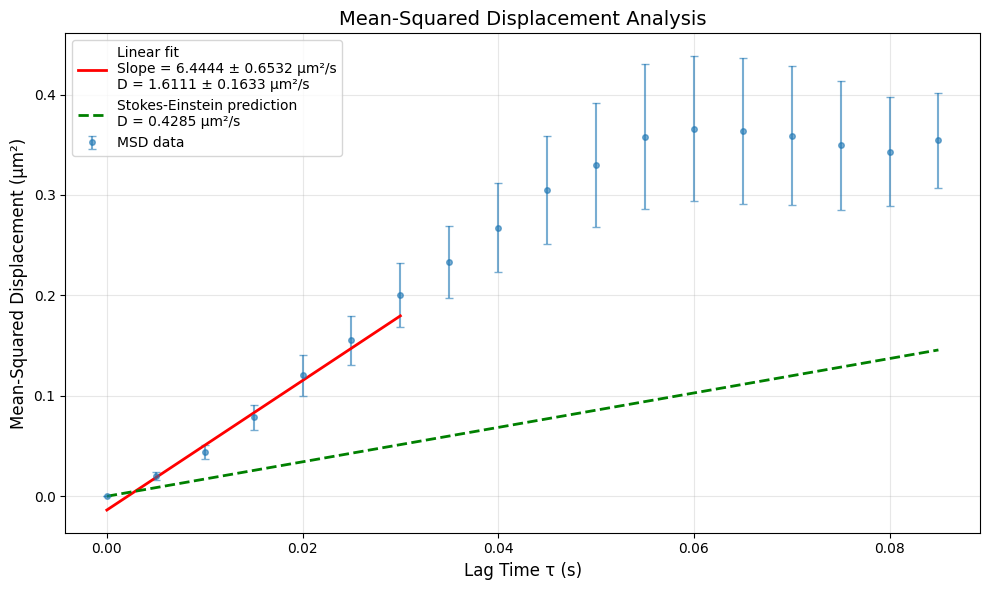

In [17]:
# Plot MSD with fit
plt.figure(figsize=(10, 6))
plt.errorbar(lag_times, MSD_um, yerr=MSD_err_um, fmt='o', 
             markersize=4, capsize=3, alpha=0.6, label='MSD data')

# Plot fit line
fit_line = linear(lag_times[:n_fit+1], slope, intercept)
plt.plot(lag_times[:n_fit+1], fit_line, 'r-', linewidth=2,
         label=f'Linear fit\nSlope = {slope:.4f} ± {slope_err:.4f} μm²/s\nD = {D_msd:.4f} ± {D_msd_err:.4f} μm²/s')

# Also plot theoretical prediction
theory_msd = 4 * D_theory_um * lag_times
plt.plot(lag_times, theory_msd, 'g--', linewidth=2, 
         label=f'Stokes-Einstein prediction\nD = {D_theory_um:.4f} μm²/s')

plt.xlabel('Lag Time τ (s)', fontsize=12)
plt.ylabel('Mean-Squared Displacement (μm²)', fontsize=12)
plt.title('Mean-Squared Displacement Analysis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 10. Summary of Results

In [18]:
print("="*60)
print("DIFFUSION COEFFICIENT SUMMARY")
print("="*60)
print(f"\nExperimental Conditions:")
print(f"  Bead diameter: {bead_diameter} μm")
print(f"  Temperature: {T} K ({T-273:.1f}°C)")
print(f"  Frame rate: {frame_rate} fps")
print(f"  Pixel size: {pixel_size} μm/px")
print(f"  Number of frames analyzed: {n_frames}")
print(f"\nDiffusion Coefficient Results:")
print(f"  Method 1 (Direct variance):    D = {D_avg_direct:.4f} μm²/s")
print(f"  Method 2 (Gaussian fit):       D = {D_avg_fit:.4f} μm²/s")
print(f"  Method 3 (MSD slope):          D = {D_msd:.4f} ± {D_msd_err:.4f} μm²/s")
print(f"  Stokes-Einstein prediction:    D = {D_theory_um:.4f} μm²/s")
print(f"\nPercent Differences from Theory:")
print(f"  Method 1: {abs(D_avg_direct - D_theory_um)/D_theory_um * 100:.1f}%")
print(f"  Method 2: {abs(D_avg_fit - D_theory_um)/D_theory_um * 100:.1f}%")
print(f"  Method 3: {abs(D_msd - D_theory_um)/D_theory_um * 100:.1f}%")
print("="*60)

DIFFUSION COEFFICIENT SUMMARY

Experimental Conditions:
  Bead diameter: 1.0 μm
  Temperature: 293 K (20.0°C)
  Frame rate: 200 fps
  Pixel size: 0.108 μm/px
  Number of frames analyzed: 36

Diffusion Coefficient Results:
  Method 1 (Direct variance):    D = 0.9018 μm²/s
  Method 2 (Gaussian fit):       D = 2.6164 μm²/s
  Method 3 (MSD slope):          D = 1.6111 ± 0.1633 μm²/s
  Stokes-Einstein prediction:    D = 0.4285 μm²/s

Percent Differences from Theory:
  Method 1: 110.5%
  Method 2: 510.6%
  Method 3: 276.0%
